<a href="https://colab.research.google.com/github/carlosibm/addCustomIotFn/blob/master/Pump_ttm_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

## Installation

In [ ]:
# Clone the ibm/tsfm
! git clone https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
remote: Enumerating objects: 1689, done.
remote: Counting objects: 100% (530/530), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 1689 (delta 299), reused 339 (delta 265), pack-reused 1159
Receiving objects: 100% (1689/1689), 18.35 MiB | 23.11 MiB/s, done.
Resolving deltas: 100% (959/959), done.


In [ ]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [ ]:
# Do ls
! ls

LICENSE   notebooks	  README.md  tests	  tsfm_public
Makefile  pyproject.toml  scripts    tsfmhfdemos  wiki.md


In [ ]:
# Install the tsfm library
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

## Imports

In [ ]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

## Important arguments

In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "ettm2"
DATA_ROOT_PATH = "/content/maximo-auto_ai_pump_data_04714B601096.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

## Data processing pipeline

In [ ]:
# Load the data file and see the columns
df_tmp = pd.read_csv(DATA_ROOT_PATH)
df_tmp

,Unnamed: 0,rcv_timestamp_utc,updated_utc,speed,head,device_id,pump_mode,flow,voltage,POWER,CURRENT
0,62,2019-12-17 08:13:33.820,2019-12-17 08:13:33.000,1160.0,57.909,04714B601096,a,141.852,288.0,3.180,9.35
1,66,2019-12-17 08:18:34.204,2019-12-17 08:18:34.000,1180.0,59.419,04714B601096,a,153.554,296.0,3.440,9.74
2,70,2019-12-17 08:23:34.315,2019-12-17 08:23:34.000,1164.0,58.150,04714B601096,a,145.109,290.0,3.230,9.44
3,74,2019-12-17 08:28:34.597,2019-12-17 08:28:34.000,1176.0,58.966,04714B601096,a,152.987,294.0,3.418,9.73
4,78,2019-12-17 08:33:34.636,2019-12-17 08:33:34.000,1175.0,59.077,04714B601096,a,151.237,294.0,3.372,9.64
...,...,...,...,...,...,...,...,...,...,...,...
65849,726845,2021-01-11 18:58:47.448,2021-01-11 18:58:47.000,1095.0,52.138,04714B601096,a,93.015,265.0,2.315,8.22
65850,726973,2021-01-11 19:03:47.512,2021-01-11 19:03:47.000,1098.0,52.438,04714B601096,a,94.139,266.0,2.318,8.20
65851,726992,2021-01-11 19:08:47.913,2021-01-11 19:08:47.000,1080.0,50.733,04714B601096,a,74.466,260.0,2.089,7.95
65852,727011,2021-01-11 19:13:48.033,2021-01-11 19:13:48.000,1077.0,50.560,04714B601096,a,70.045,259.0,2.040,7.82


<Axes: xlabel='updated_utc'>

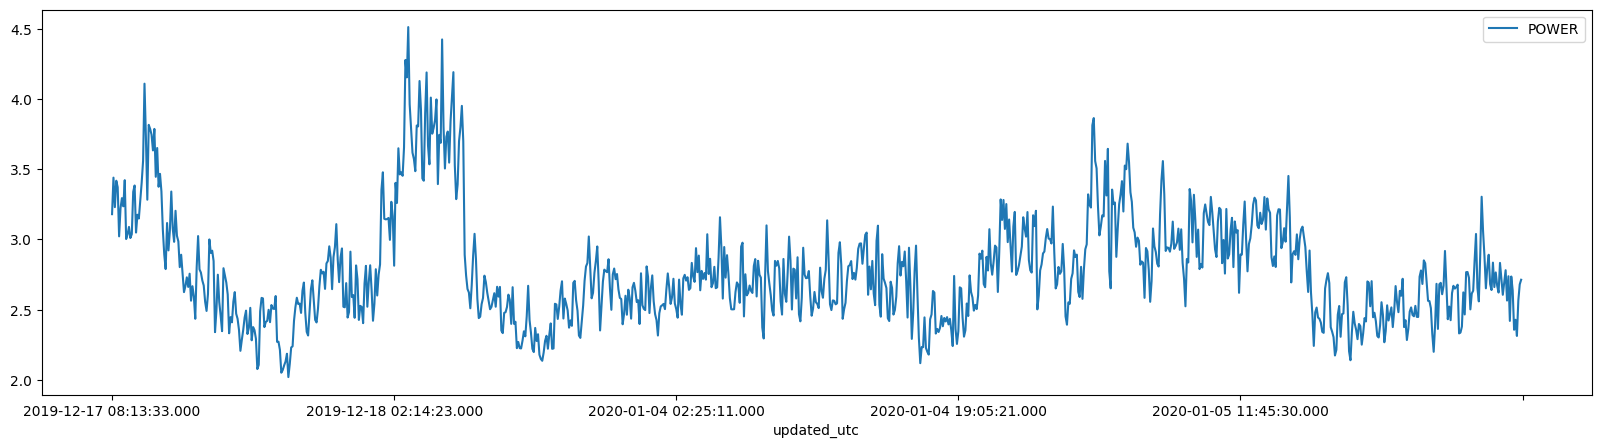

In [ ]:
df_tmp.iloc[:1000].plot(x="updated_utc", y="POWER", figsize=(20,5))

In [ ]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

dataset_path = DATA_ROOT_PATH
timestamp_column = "updated_utc"
id_columns = []
target_columns = ["speed", "head", "flow", "voltage", "POWER", "CURRENT"]
split_config = {
                "train": [0, 12 * 30 * 24 * 4],
                "valid": [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4],
                "test": [
                    12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,
                    12 * 30 * 24 * 4 + 8 * 30 * 24 * 4,
                ],
            }
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

<ipython-input-15-e9df361a30b1>:38: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Data lengths: train = 1607, val = 11425, test = 11425


In [ ]:
train_dataset[3]

{'past_values': tensor([[1.3620, 1.3346, 1.4939, 1.2917, 1.3477, 1.4690],
         [1.3459, 1.3550, 1.4591, 1.2917, 1.2939, 1.3874],
         [0.9264, 0.9379, 1.1392, 0.8530, 0.8845, 0.9613],
         ...,
         [0.3456, 0.3418, 0.6302, 0.2827, 0.3477, 0.4446],
         [0.3295, 0.3558, 0.5968, 0.2827, 0.3185, 0.3721],
         [0.3133, 0.3141, 0.6055, 0.2827, 0.3267, 0.4084]]),
 'future_values': tensor([[ 7.9734e-01,  8.1486e-01,  1.0235e+00,  7.2138e-01,  7.4653e-01,
           8.0723e-01],
         [ 8.4574e-01,  8.1284e-01,  1.0952e+00,  8.0913e-01,  8.3542e-01,
           9.1602e-01],
         [ 6.6827e-01,  6.7044e-01,  9.1716e-01,  6.3364e-01,  6.4712e-01,
           6.8938e-01],
         [ 2.0039e-01,  2.0718e-01,  4.6476e-01,  1.5106e-01,  1.9801e-01,
           2.0892e-01],
         [ 2.8106e-01,  2.9015e-01,  5.5086e-01,  2.3880e-01,  2.7754e-01,
           3.2677e-01],
         [ 3.2946e-01,  3.3909e-01,  6.1857e-01,  2.8267e-01,  3.3134e-01,
           3.5396e-01],
    

## Zero-shot evaluation method

In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION)
zeroshot_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [ ]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [ ]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.07015623152256012,
 'eval_runtime': 98.0515,
 'eval_samples_per_second': 116.52,
 'eval_steps_per_second': 1.826}

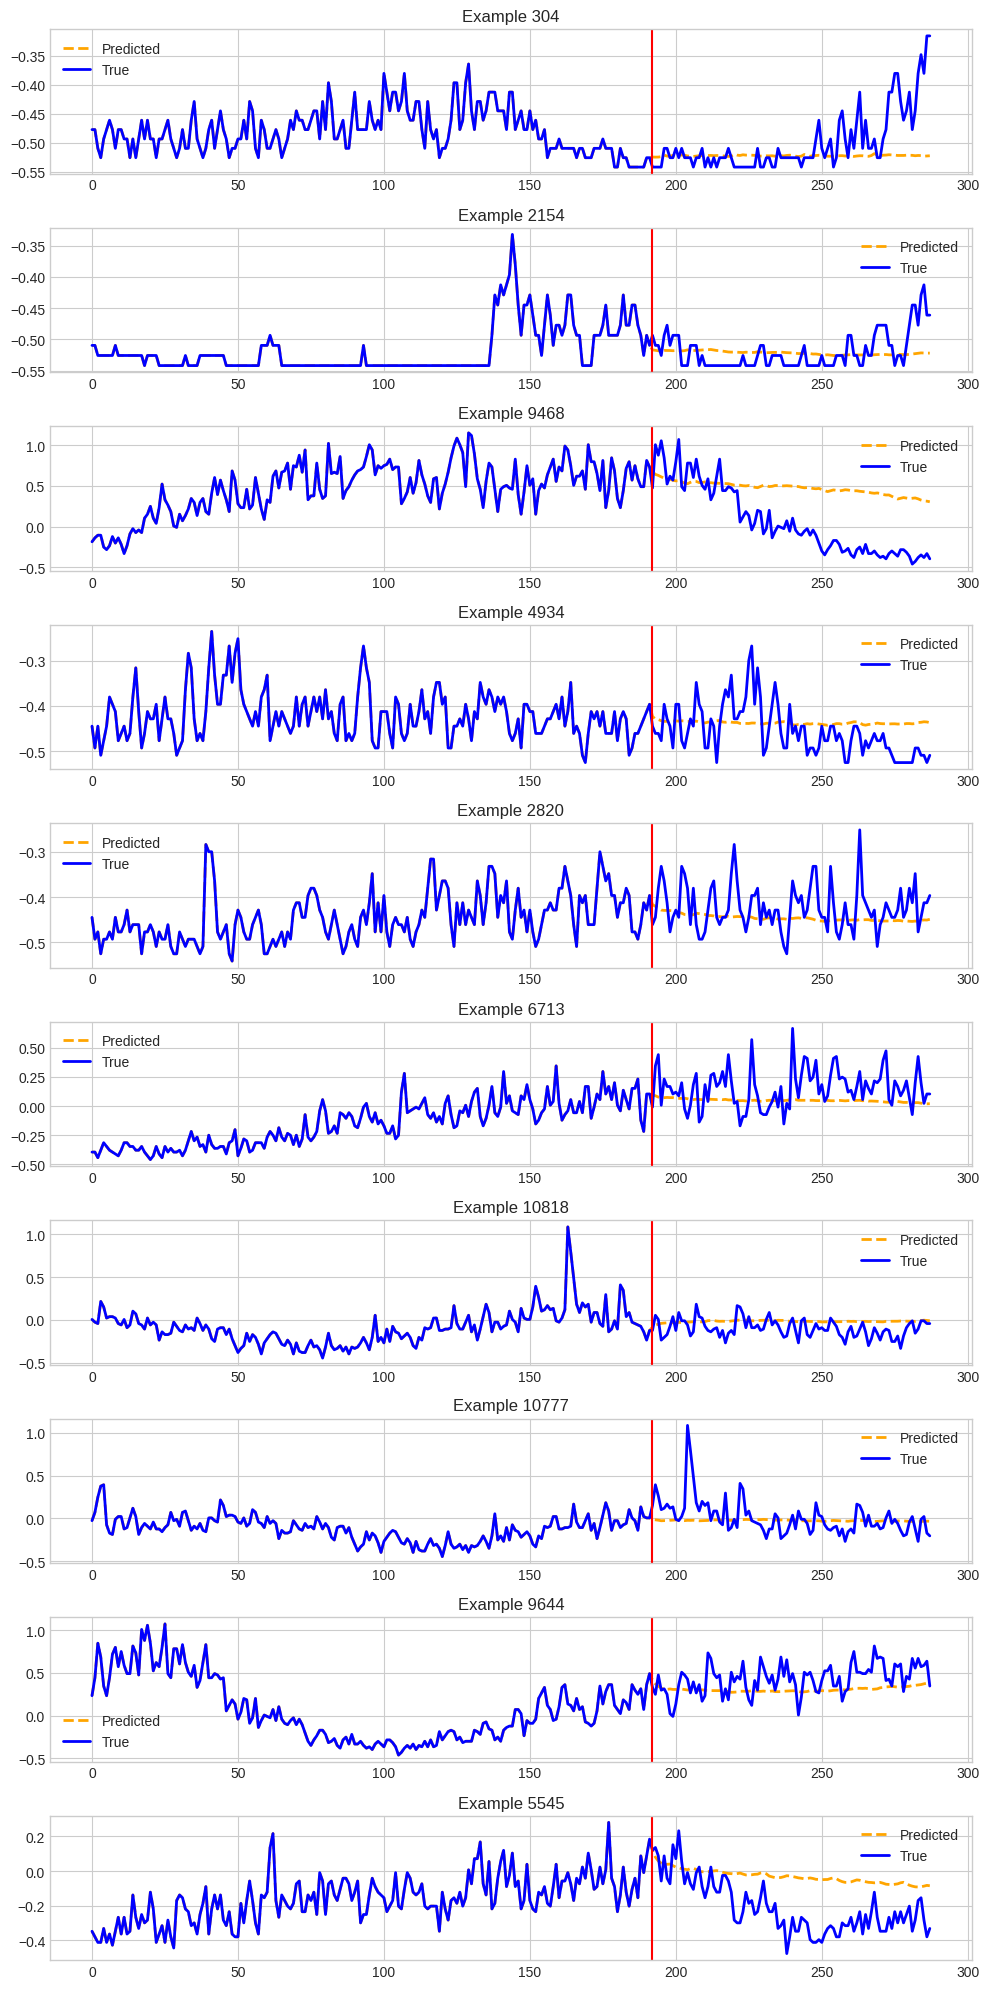

In [ ]:
# plot
plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "ettm2"), plot_prefix="test_zeroshot", channel=0)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [ ]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.7)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

### Frezze the TTM backbone

In [ ]:
print(
        "Number of params before freezing backbone",
        count_parameters(finetune_forecast_model),
    )

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


### Finetune few-shot 5%

In [ ]:
# Important parameters
learning_rate = 0.001
num_epochs = 1 # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [ ]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
1,0.622600,0.000854


[TrackingCallback] Mean Epoch Time = 18.228879690170288 seconds, Total Train Time = 85.98447299003601


TrainOutput(global_step=26, training_loss=0.6225686440101037, metrics={'train_runtime': 85.9913, 'train_samples_per_second': 18.688, 'train_steps_per_second': 0.302, 'total_flos': 23852573982720.0, 'train_loss': 0.6225686440101037, 'epoch': 1.0})

In [ ]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 0.061879947781562805,
 'eval_runtime': 67.826,
 'eval_samples_per_second': 168.446,
 'eval_steps_per_second': 2.639,
 'epoch': 1.0}

## Hands-on Questions

### Q 15.	Zero-shot on etth1.
In your notebook, modify the zero-shot code to try it on etth1 dataset. Etth1 is available on https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv.
Use the following train/val/test splits:
```
split_config = {
                "train": [0, 12 * 30 * 24],
                "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
                "test": [
                    12 * 30 * 24 + 4 * 30 * 24,
                    12 * 30 * 24 + 8 * 30 * 24,
                ],
            }
```

### Q 16.	Zero-shot on etth1 by truncating the length
Let’s say your application needs to forecast 24 hours in the future. You can still use the 512-96 TTM model and set `prediction_filter_length=24` argument during model loading. Try it on etth1, and note the evaluation error (on all channels)?

### Q 17.	Few-shot on etth1
Try few-shot 5% forecasting on etth1. Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

### Q 18.	Few-shot on etth1 by changing loss function
Try few-shot 5% forecasting on etth1 by changing the `loss` to `mae` (mean absolute error). Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

### Q 19.	Zero-shot on channel 0 and 2 for etth1
In your notebook, add `prediction_channel_indices=[0,2]` during model loading to forecast only 0th and 2nd channels. In this case, execute the following code and note the output shape.
```
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape
```